In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge
from scipy.stats import skew

%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load training dataset
train_df = pd.read_csv('dataset/kaggle-house-price/train.csv')
rows_train = train_df.shape[0]
test_df = pd.read_csv('dataset/kaggle-house-price/test.csv')
all_data = pd.concat([train_df, test_df])

# null values
def null_values_per_col(df):
    """
    Returns a Pandas Series containing the number of null values for each
    column which has atleast 1 null value.
    """
    null_cols_all = df.apply(lambda x: x.size - x.count())
    null_cols = pd.Series()

    for col, val in null_cols_all.iteritems():
        if val > 0:
            null_cols[col] = val

    return null_cols

print "null values:"
null_values_per_col(all_data)

null values:


Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

**Fill null values 'NA' wherever possible.**

In [3]:
def fill_cols_with_val(df, cols, val):
    """
    Fill the columns specified in the DataFrame df with val
    """
    for col in cols:
        df[col].fillna(val, inplace=True)

NA_cols = ['Alley', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'BsmtFinType2',
           'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual']

# fill with 'NA'
fill_cols_with_val(all_data, NA_cols, 'NA')

# remaining columns with null values
null_values_per_col(all_data)

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Functional         2
GarageArea         1
GarageCars         1
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

**Fill rest of the null values with appropriate values.**

In [4]:
zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
             'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# fill with zero
fill_cols_with_val(all_data, zero_cols, 0)

mode_cols = ['Exterior1st', 'Exterior2nd', 'Electrical', 'Functional', 'KitchenQual',
             'MSZoning', 'SaleType', 'Utilities']

# fill with mode
for col in mode_cols:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

all_data['MasVnrType'].fillna('None', inplace=True)
all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean(), inplace=True)

# remaining columns with null values
null_values_per_col(all_data)

GarageYrBlt     159
SalePrice      1459
dtype: int64

**Encode categories using LabelEncoder**

In [5]:
# Encode categories
only_strings = all_data.select_dtypes(include=['object'])
only_strings = only_strings.apply(LabelEncoder().fit_transform)
all_data[only_strings.columns.values] = only_strings
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,0,4,4,706.0,0.0,...,8,0,1,8,856.0,0,0,2003,2003,2008
1,1262,0,0,1,3,0,4,1,978.0,0.0,...,8,0,1,6,1262.0,0,298,1976,1976,2007
2,920,866,0,1,3,0,4,2,486.0,0.0,...,8,0,1,6,920.0,0,0,2001,2002,2008
3,961,756,0,1,3,0,1,4,216.0,0.0,...,8,0,1,7,756.0,0,0,1915,1970,2006
4,1145,1053,0,1,4,0,4,0,655.0,0.0,...,8,0,1,9,1145.0,0,192,2000,2000,2008


**Find skewed features and log transform them**

In [6]:
numeric_cols = all_data.dtypes[all_data.dtypes != 'object'].index
date_price_cols = ['GarageYrBlt', 'MoSold', 'YearBuilt',
                   'YearRemodAdd', 'YrSold', 'SalePrice']

# remove date and price fields from numeric cols
for col in date_price_cols:
    numeric_cols = numeric_cols.delete(np.argwhere(numeric_cols == col))

skewed_features = all_data[numeric_cols].apply(lambda x: skew(x))
skewed_features = skewed_features[np.abs(skewed_features) > 0.7]
skewed_features = skewed_features.index

# log transform skewed features
all_data[skewed_features] = all_data[skewed_features].apply(lambda x: np.log1p(x))

**Apply LassoCV**

In [7]:
train_data = all_data[0:rows_train]
# log transform sale price since its skewed
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
test_data = all_data[rows_train:]
test_data.drop('SalePrice', axis=1, inplace=True)

x_features = train_data.columns.values.tolist()
x_features.remove('SalePrice')
# remove 'GarageYrBlt' since its unimportant and no default can be applied.
x_features.remove('GarageYrBlt')

X = train_data[x_features]
y = train_data['SalePrice']

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


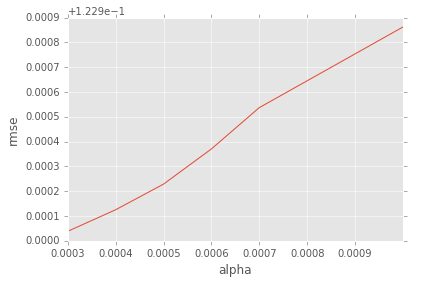

In [8]:
# split dataset into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# function for calculating rmse
def rmse_cv(model, X_train, y, cv=5):
    """
    Returns the root mean square error
    """
    cvs = -(cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=cv))
    return np.sqrt(cvs)

# find optimum alpha value
alphas = [0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.001]
cv_lasso = [rmse_cv(Lasso(alpha=alpha), X_train, y_train).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index=np.log1p(alphas))
cv_lasso.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [9]:
# make lasso model with alpha = 0.0004
lso = Lasso(alpha=0.0003)
lso.fit(X_train, y_train)

Lasso(alpha=0.0003, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso model selected 70 variables out of 79 variables


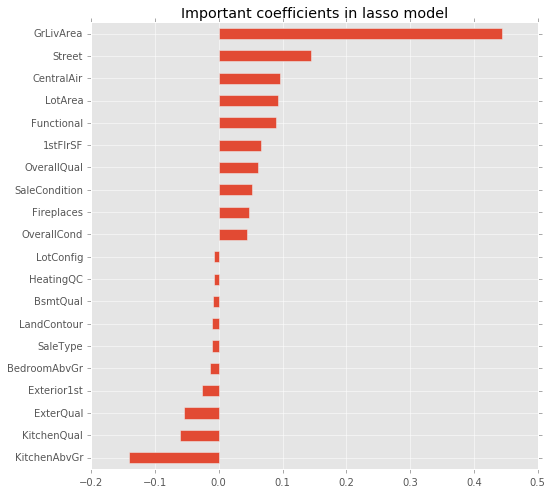

In [10]:
coef = pd.Series(lso.coef_, index=X_train.columns)
vars_selected = sum(coef != 0)
print "Lasso model selected %d variables out of %d variables" % (vars_selected, len(X_train.columns))

# important features
sorted_coeffs = coef.sort_values()
imp_coeffs = pd.concat([sorted_coeffs.head(10), sorted_coeffs.tail(10)])
important_feats = imp_coeffs.index
# plot important coefficients in the lasso model
plt.figure(figsize=[8, 8])
imp_coeffs.plot(kind='barh')
plt.title("Important coefficients in lasso model")
plt.show();

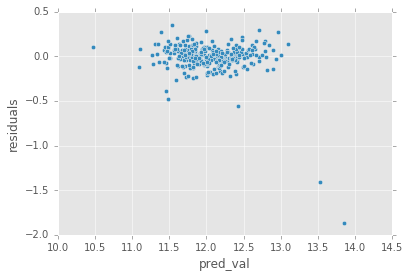

In [11]:
predictions = pd.DataFrame({'pred_val': lso.predict(X_test), 'true_val': y_test})
plt.figure(figsize=[10, 10])
predictions['residuals'] = predictions['true_val'] - predictions['pred_val']
predictions.plot(x='pred_val', y='residuals', kind='scatter');
plt.show()

In [12]:
train_X = X[important_feats]
train_y = y

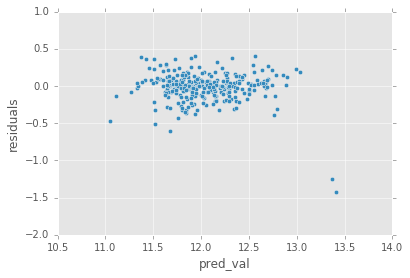

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=47)

etr_model = ExtraTreesRegressor(n_estimators=5)
etr_model.fit(X_train, y_train)

predictions = pd.DataFrame({'pred_val': etr_model.predict(X_test), 'true_val': y_test})
plt.figure(figsize=[10, 10])
predictions['residuals'] = predictions['true_val'] - predictions['pred_val']
predictions.plot(x='pred_val', y='residuals', kind='scatter');
plt.show()

In [14]:
test_X = test_data[important_feats]
y_pred = etr_model.predict(test_X)
test_data['SalePrice'] = y_pred

id_price = test_data[['Id', 'SalePrice']]
id_price.to_csv('outputs/house_price_ext_tree1.csv', index=False)